# Claim Prediction using Julia

In [1]:
using Flux, CSV, DataFrames, Statistics
using Plots, MLJ, MLUtils, ClassImbalance
using MLJ: partition
using Flux: Dense, train!
using ClassImbalance: smote

We load Australian private auto insurance claim data from 2004, sourced from R's 'CASdatasets' package. Original reference: P. De Jong and G.Z. Heller (2008), Generalized linear models for insurance data, Cambridge University Press.

In [2]:
data = DataFrame(CSV.File("../data/ausprivauto0405.csv"))

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge
,Float64,Float64,String15,String31,String7,String31
1,0.303901,1.06,old cars,Hatchback,Female,young people
2,0.648871,1.03,young cars,Hatchback,Female,older work. people
3,0.569473,3.26,young cars,Utility,Female,young people
4,0.317591,4.14,young cars,Station wagon,Female,young people
5,0.648871,0.72,oldest cars,Hatchback,Female,young people
6,0.854209,2.01,old cars,Hardtop,Male,older work. people
7,0.854209,1.6,old cars,Panel van,Male,older work. people
8,0.555784,1.47,young cars,Hatchback,Male,oldest people
9,0.361396,0.52,oldest cars,Hatchback,Female,working people


`ClaimOcc` is the target variable, and we create a binary indicator from it and drop `ClaimNb` and `ClaimAmount` as features.

In [3]:
data = select!(data, Not(:ClaimNb));
data = select!(data, Not(:ClaimAmount));

We apply min-max scaling to the `VehValue`:

In [4]:
minmax(x) = (x .- minimum(x))./(maximum(x) .- minimum(x))
data[:, :VehValue] = minmax(data[:, :VehValue]);

In [5]:
function dummy_encode(x, name)::DataFrame
## Purpose: dummy encodes a given vector, with the first entry dropped 
## as a baseline.
## Input: vector of Strings and a name to assign subseqent columns
## Output: DataFrame
    u = unique(x)
    df = DataFrame()
    for i ∈ eachindex(u)
        colname = "$name" * "$i"
        df[!, colname] = x .== u[i]
    end
    return df[!, (1:end) .!= 1]
end

dummy_encode (generic function with 1 method)

In [6]:
function dummy_encode_all(X::DataFrame)::DataFrame
## Purpose: dummy encodes all String columns in a DataFrame
## Input: A DataFrame
## Output: A DataFrame
    df = DataFrame()
    for i ∈ 1:size(X, 2)
        if string(typeof(data[1, i])) ∉ ["Float64", "Int64", "Int8", "Int16", "Int32"]
            de = dummy_encode(X[!, i], names(X)[i])
            for c ∈ names(de)
                df[!, c] = de[!, c]
            end
        else
            df[!, names(X)[i]] = X[!, i]
        end
    end
    return df
end

dummy_encode_all (generic function with 1 method)

We dummy encode our `DataFrame` and transform it into a matrix for Flux to interpret.

In [7]:
data_encode = Matrix{Float64}(dummy_encode_all(data));

In [8]:
X = data_encode[:, 1:(end-1)]
y = data_encode[:, end];

In [9]:
function low_variance_filter(X; t=0.001)
## Purpose: drops columns with low/zero variance
## Input: A Matrix (DataFrame untested), a threshhold t (default=0.001)
## Output: A Matrix (DataFrame untested)
    l = zeros(0)
    for c ∈ 1:size(X, 2)
        if var(X[:, c]) ≤ t
            append!(l, c)
        end
    end
    return X[:, (1:end) .∉ (l,)] 
end

low_variance_filter (generic function with 1 method)

In [10]:
X = low_variance_filter(X; t=0.01);

We apply SMOTE in order to address class imbalance in the training set:

In [11]:
smote_X, smote_y = smote(X, vcat(y...), k = 5, pct_under = 400, pct_over = 100);

By using `partition()`, we ensure the distribution of out target variable is evenly dispersed:

In [12]:
train, test = partition(eachindex(y), 0.7)
train_X, train_y = smote_X, smote_y 
train_data = [(train_X', train_y')];

We keep a testing set imbalances like original data.

In [13]:
test_X = X[test, :]
test_y = y[test];

We construct an ANN with two hidden layer of 40 neurons and 25 neurons, respectively. The tanh activation function scales inputs between -1 and 1 and introduces non-linearity.

In [14]:
n_features = size(train_X, 2)
model = Chain(Dense(n_features, 40, tanh), Dense(40, 25, tanh), Dense(25, 1, sigmoid))
β = Flux.params(model);

NAdam is chosen as the optimiser and MSE the loss function:

In [15]:
δ = NAdam()
ℓ(x, y) = Flux.Losses.mse(model(x), y);

We train using 1'000 epochs (for demonstrative purposes) and display the loss every N/10 epochs for transparency.

In [16]:
println("Starting training...")
ℓ(train_X', train_y')

Starting training...


0.2606646663574626

In [17]:
N = 1_000;

In [18]:
epochs = zeros(N)
for epoch ∈ 1:N
    Flux.train!(ℓ, β, train_data, δ)
    epochs[epoch] = ℓ(train_X', train_y')
    if epoch % (N/10) == 0
        @show epoch
        @show ℓ(train_X', train_y')
    end
end

epoch = 100
ℓ(train_X', train_y') = 0.20965709730921606
epoch = 200
ℓ(train_X', train_y') = 0.2069033815059925
epoch = 300
ℓ(train_X', train_y') = 0.20650939001764948
epoch = 400
ℓ(train_X', train_y') = 0.20602151330658106
epoch = 500
ℓ(train_X', train_y') = 0.2053408273269187
epoch = 600
ℓ(train_X', train_y') = 0.2045950392679257
epoch = 700
ℓ(train_X', train_y') = 0.20412167082497348
epoch = 800
ℓ(train_X', train_y') = 0.20380061793622672
epoch = 900
ℓ(train_X', train_y') = 0.2034385559361532
epoch = 1000
ℓ(train_X', train_y') = 0.20299114135534757


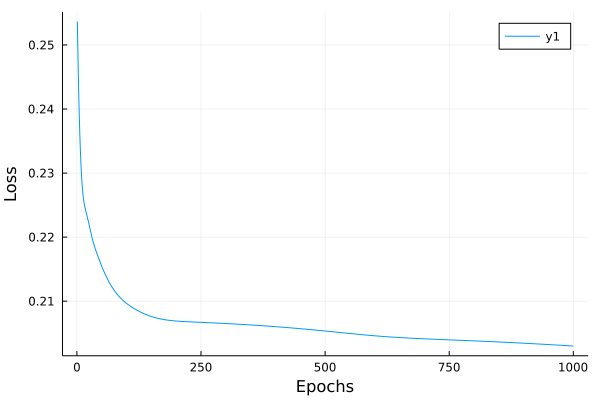

In [19]:
gr()
display(plot(1:N, epochs, xlabel = "Epochs", ylabel = "Loss"))

Once trained, our model that generates the predictions assigns a 1 (at least one claim has occured) to all output values from the sigmoid output function greater than 0.5 and zero otherwise (no claim has occured).

In [20]:
predict(x) = model(x) .> 0.5

predict (generic function with 1 method)

In [21]:
function confusion_matrix(y, ŷ)::Matrix
## Purpose: Generates a confusion matrix for binary target variables
## Input: A vector of actuals and a vector of predictions
## Outpus: Returns a 2x2 matrix
    C = zeros(2, 2)
    for i ∈ 0:1
        for j ∈ 0:1
            C[i+1, j+1] = sum((y .== i) .& (ŷ .== j))
        end
    end
    return C
end

confusion_matrix (generic function with 1 method)

In [22]:
function metrics(C::Matrix)
## Purpose: Returns a tuple of standard performance metrics for binary classification using a confusion matrix
## Input: A 2x2 confusion matrix
## Output: A named tuple
    accuracy = (C[1, 1]+C[2, 2])/(C[1, 1]+C[1, 2]+C[2, 1]+C[2, 2])
    precision = C[1, 1]/(C[1, 1]+C[2, 1])
    recall = C[1, 1]/(C[1, 1]+C[1, 2])
    F1_score = 2*(precision*recall)/(precision+recall)
    return (Accuracy = accuracy, Precision = precision, Recall = recall, F1_Score = F1_score)
end

metrics (generic function with 1 method)

Our final model can now be validated on unseen testing data:

In [23]:
println("Predict on unseen data...")
CM = confusion_matrix(test_y', predict(test_X'));

Predict on unseen data...


In [24]:
@show metrics(CM)
display(CM)

metrics(CM) = (Accuracy = 0.8603920027508964, Precision = 0.9349289048084228, Recall = 0.91293057763646, F1_Score = 0.9237987987987988)


2×2 Matrix{Float64}:
 17227.0  1643.0
  1199.0   288.0